In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions= actions # a list
        self.lr= learning_rate
        self.gamma= reward_decay
        self.epsilon= e_greedy
        self.q_table= pd.DataFrame(columns= self.actions, dtype= np.float64)
        
    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.uniform()<self.epsilon:
            # Choose the random action
            action= np.random.choice(self.actions)
        else:
            # Choose the best action
            state_action= self.q_table.loc[observation, :]
            #Some actions have same value
            state_action= state_action.reindex(np.random.permutation(state_action.index))
            action= state_action.idxmax()   
        return action
    
    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        q_predict= self.q_table.loc[s, a]
        
        if s!='terminal':
            q_target= r+ self.gamma*self.q_table.loc[s_,:].max()
        else:
            q_target= r
            
        self.q_table.loc[s,a]+=  self.lr*(q_target- q_predict) #updating q-value
        
        
    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table= self.q_table.append(
            pd.Series([0]*len(self.actions),
                     index= self.q_table.columns, 
                     name=state))
            
        
    
            

In [34]:
class DSA_Markov():
    def __init__(self,
                n_channel,
                n_su,
                sense_error_prob_max=0.2,
                punish_interfer_PU=-2):
        self.n_channel= n_channel # The number of channels
        self.n_su= n_su # then number of secondary users
        
        # Initialize the Markov channels
        self._build_Markov_channel()
        
        # Initialize the locations of SUs and PUs
        self._build_location()
        
        # Set the noise(Mw)
        self.Noise= 1*np.float_power(10,-8)
        # Set the carrier frequency (5 Ghz)
        self.fc= 5
        # Set the k in channel gain
        self.k= 8
        # Set the power of PU and SU(mw)
        self.SU_power= 20
        self.PU_power= 40
        
        # Initialize SINR(no consideration of interference of SUs)
        self.render_SINR()
        
        self.n_actions= n_channel+1 # The action space size
        self.n_features= n_channel # The sensing result space
        
        self.sense_error_prob_max= sense_error_prob_max
        self.sense_error_prob= np.random.uniform(0, self.sense_error_prob_max, size=(self.n_su, self.n_channel))
        
        # The punishment for interferring PUs
        self.punish_interfer_PU= punish_interfer_PU
        
    def _build_Markov_channel(self):
        # Initialize channel state(uniform distribution)
        # 1: Inactive Pu
        # 0: Active Pu
        
        self.channel_state= np.random.choice(2, self.n_channel)
        
        # Initialize the transition probability of independent channels
        self.stayGood_prob= np.random.uniform(0.7, 1, self.n_channel)
        self.stayBad_prob= np.random.uniform(0, 0.3, self.n_channel)
        self.goodToBad_prob= 1- self.stayGood_prob
        self.badToGood_prob= 1- self.stayBad_prob
        
    def _build_location(self):
        # Initialize the location of PUs
        self.PU_TX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_TX_y= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_y= np.random.uniform(0, 150, self.n_channel)
        
        
        # Initialize the location of SUs transmitters
        self.SU_TX_x= np.random.uniform(0+40, 150-40, self.n_su)
        self.SU_TX_y= np.random.uniform(0+40, 150-40, self.n_su)
        
        # Initialize the distance between SU's transmitter and receiver
        self.SU_d= np.random.uniform(20, 40, self.n_su)
        
        # Initialize the location of SUs receivers
        SU_theda= 2*np.pi*np.random.uniform(0, 1, self.n_su)
        SU_dx= self.SU_d*np.cos(SU_theda)
        SU_dy= self.SU_d*np.sin(SU_theda)
        self.SU_RX_x= self.SU_TX_x+ SU_dx
        self.SU_RX_y= self.SU_TX_y+ SU_dy
        
        # Compute the distance between PU_Tx and SU_Rx
        self.SU_RX_PU_TX_d= np.zeros((self.n_su, self.n_channel))
        for k in range(self.n_su):
            for l in range(self.n_channel):
                self.SU_RX_PU_TX_d[k][l]= np.sqrt(
                np.float_power((self.SU_RX_x[k]-self.PU_TX_x[l]),2)+
                    np.float_power((self.SU_RX_y[k]-self.PU_TX_y[l]), 2)
                )
        
        # Compute the distance between SU_TX and SU_RX
        self.SU_RX_SU_TX_d= np.zeros((self.n_su, self.n_su))
        for k1 in range(self.n_su):
            for k2 in range(self.n_su):
                self.SU_RX_SU_TX_d[k1][k2]= np.sqrt(
                np.float_power(self.SU_RX_x[k1]-self.SU_TX_x[k2], 2)+
                    np.float_power(self.SU_RX_y[k1]-self.SU_TX_y[k2], 2)
                )
        # Plot the locations
        plt.plot(self.PU_TX_x, self.PU_TX_y,'ro',label='PU_TX' )
        plt.plot(self.PU_RX_x, self.PU_RX_y,'rx' ,label='PU_RX')
        plt.plot(self.SU_TX_x, self.SU_TX_y,'bs',label='SU_TX')
        plt.plot(self.SU_RX_x, self.SU_RX_y,'b^',label='SU_RX')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()
        
        
    def store_action(self, action):
        self.action= action
        
    def sense(self):
        tmp_dice= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        error_index= tmp_dice< self.sense_error_prob # True: sensing error happens, False: sensing is correct
        
        # Get the sensing result
        self.sensing_result= self.channel_state*(1-error_index)+ (1-self.channel_state)*error_index
        return self.sensing_result

    def access(self, action):
        # action[0 - n_channel-1]: 
        # action n_channel:
        self.success=0
        self.fail_PU=0
        self.fail_collision=0
        
        self.reward= np.zeros(self.n_su)
        
            # To check the number of same actions
        def eqlen(a, b):
            i=0
            for j in range(len(a)):
                if a[j]==b:
                    i=i+1
            return i
        #Calculate the interference of SUs
        Interference_SU=0
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_SU_TX_d)+20*np.log10(self.fc/5))/10))
        
        for k in range(self.n_su):
            SU_sigma2[k][k]=0
            
        for k in range(self.n_su):
            if (action[k]==self.n_channel): # Not choosing any channel
                self.reward[k]=0
            else: 
                for q in range(self.n_su):
                    if (action[q]==action[k]):
                        Interference_SU= Interference_SU+ SU_sigma2[k][q]*self.SU_power
                SINR= self.H2[k, action[k]]*self.PU_power/(Interference_SU+self.Interference_PU[k, action[k]]+self.Noise)
                self.reward[k]= np.log2(1+SINR)
                
                if (self.channel_state[action[k]]==1):
                    #if len(np.where(np.equal(action, action[k]))[0])==1:
                    
                    if eqlen(action, action[k])==1:
                        #Successful transmission
                        self.success=self.success+1
                    else:
                        #Collision with SU
                        self.fail_collision=self.fail_collision+1
                        
                else:
                    #collision with PU
                    self.fail_PU=self.fail_PU+1
                    self.reward[k]= self.punish_interfer_PU
                    #if len(np.where(np.equal(action, action[k]))[0])> 1:
                    if eqlen(action, action[k])>1:
                        #Collision with Su
                        self.fail_collision=self.fail_collision+1
        return self.reward
                
                
    def render(self):
        # The probability of staying in current state in next time-slot
        stay_prob= self.channel_state*self.stayGood_prob + (1-self.channel_state)*self.stayBad_prob
        
        
    def render_SINR(self):
        # Update the SINR
        
        # Calculate the channel gain
        SU_d= copy.deepcopy(np.reshape(self.SU_d, (-1, 1)))
        for n in range(self.n_channel-1):
            SU_d= np.hstack((SU_d, np.reshape(self.SU_d, (-1, 1))))
            
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(SU_d)+ 20*np.log10(self.fc/5))/10))
        CN_real= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        CN_imag= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        theda= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        H= np.sqrt(self.k/(self.k+1)*SU_sigma2)*np.exp(1j*2*np.pi*theda)+np.sqrt(1/(self.k+1)*SU_sigma2/2)*(CN_real+1j*CN_imag)
        self.H2= np.float_power(np.absolute(H), 2)
        
        # Calculate the interference of PUs
        PU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_PU_TX_d)+ 20*np.log10(self.fc/5))/10))
        channel_state= np.array([self.channel_state for k in range(self.n_su) ])
        self.Interference_PU= self.PU_power*PU_sigma2*(1-channel_state)
        
        self.SINR= self.H2*self.SU_power/(self.Interference_PU+self.Noise)

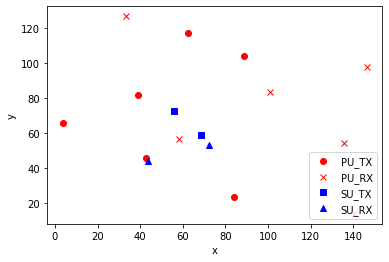

Training time= 2000; success=1428; fail_PU=361; fail_collision=133
overall_reward_3=4.8436
Training time= 4000; success=1420; fail_PU=358; fail_collision=265
overall_reward_3=4.8041
Training time= 6000; success=1453; fail_PU=327; fail_collision=413
overall_reward_3=4.9747
Training time= 8000; success=1448; fail_PU=327; fail_collision=566
overall_reward_3=4.9399
Training time= 10000; success=1434; fail_PU=338; fail_collision=721
overall_reward_3=4.8817
Training time= 12000; success=1413; fail_PU=357; fail_collision=878
overall_reward_3=4.8029
Training time= 14000; success=1451; fail_PU=348; fail_collision=1012
overall_reward_3=4.9400
Training time= 16000; success=1433; fail_PU=360; fail_collision=1153
overall_reward_3=4.8788
Training time= 18000; success=1448; fail_PU=324; fail_collision=1296
overall_reward_3=4.9443
Training time= 20000; success=1426; fail_PU=343; fail_collision=1454
overall_reward_3=4.8406
Training time= 22000; success=1439; fail_PU=347; fail_collision=1604
overall_rew

Training time= 176000; success=1438; fail_PU=335; fail_collision=12579
overall_reward_3=4.8944
Training time= 178000; success=1429; fail_PU=355; fail_collision=12718
overall_reward_3=4.8379
Training time= 180000; success=1448; fail_PU=352; fail_collision=12842
overall_reward_3=4.9193
Training time= 182000; success=1446; fail_PU=345; fail_collision=12972
overall_reward_3=4.9289
Training time= 184000; success=1456; fail_PU=323; fail_collision=13120
overall_reward_3=4.9835
Training time= 186000; success=1425; fail_PU=359; fail_collision=13261
overall_reward_3=4.8303
Training time= 188000; success=1457; fail_PU=341; fail_collision=13396
overall_reward_3=4.9685
Training time= 190000; success=1475; fail_PU=340; fail_collision=13510
overall_reward_3=5.0299
Training time= 192000; success=1474; fail_PU=337; fail_collision=13621
overall_reward_3=5.0289
Training time= 194000; success=1437; fail_PU=345; fail_collision=13774
overall_reward_3=4.8874
Training time= 196000; success=1459; fail_PU=342; 

In [36]:




if __name__=="__main__":
    random_seed= 3
    np.random.seed(random_seed)
    
    # Initialize the environment
    n_channel=6
    n_su=2
    env=DSA_Markov(n_channel, n_su)
    env_copy= copy.deepcopy(env)
    
    # Training parameters
    if n_channel==6:
        batch_size=2000
    elif n_channel==22:
        batch_size=4000
    
    replace_target_iter=1
    total_episode= batch_size*replace_target_iter*140
    epsilon_update_period= batch_size*replace_target_iter*20
    e_greedy= [0.3, 0.9, 1]
    learning_rate=0.01
    
    
    
    flag_QLearning= True
    
    
    
                
    '''Compare with Q-Learning'''   
    if flag_QLearning:
        # For fair comparision, initialize the DSA environment with same properties
        env= copy.deepcopy(env_copy)
        
        # Initialize the Q-table for each SU
        QL_list=[]
        epsilon_index= np.zeros(n_su, dtype= int)
        for k in range(n_su):
            QL_tmp= QLearningTable(actions= list(range(env.n_actions)),learning_rate= learning_rate, 
                                   reward_decay=0.9,
                                  e_greedy=e_greedy[0])
            QL_list.append(QL_tmp)
        
        # SU sense the environment and get the sensing result
        observation= env.sense()
        
        # Initialize the state and state_
        state=[ [] for i in range(n_su)]
        state_= [[] for i in range(n_su)]
        for k in range(n_su):
            state[k]= observation[k,: ]
            
        #Initialize some record values
        reward_sum= np.zeros(n_su)
        overall_reward_3= []
        success_hist_3= []
        fail_PU_hist_3=[]
        fail_collision_hist_3=[]
        success_sum=0
        fail_PU_sum=0
        fail_collision_sum=0
        
        
        
        action= np.zeros(n_su).astype(np.int32)
        for step in range(total_episode):
            # SU choose action based on observation
            for k in range(n_su):
                action[k]= QL_list[k].choose_action(str(state[k]))
            # Update the environment based on independent Markov chain
            
            env.render()
            env.render_SINR()
            
            # SU take action and obtain reward
            reward= env.access(action)
            
            # Record reward, interference, collision
            reward_sum= reward_sum+reward
            # Record the number of successful transmission
            success_sum= success_sum+env.success
            # Record the number of collsion with PU
            fail_PU_sum= fail_PU_sum+env.fail_PU
            # Record the number of collision with SU
            fail_collision_sum= fail_collision_sum+env.fail_collision
            
            
            # SU sense the environment and get sensing result(contains sensing error)
            observation_= env.sense()
            
            # Store one episode(s, a, r, s_)
            for k in range(n_su):
                state[k]= observation[k, :]
                state_[k]= observation_[k, :]
                
            # Each SU learns their QL model
            for k in range(n_su):
                QL_list[k].learn(str(state[k]), action[k], reward[k], str(state_[k]))
                
            if ((step+1)%batch_size==0):
                # Record reward, number of success/interference/collision
                overall_reward_3.append(np.sum(reward_sum)/batch_size/n_su)
                success_hist_3.append(success_sum/n_su)
                fail_PU_hist_3.append(fail_PU_sum/n_su)
                fail_collision_hist_3.append(fail_collision_sum/n_su)
                
                # After one batch, refresh the record
                reward_sum= np.zeros(n_su)
                success_sum=0
                fail_PU_sum=0
                fail_collsion_sum=0
                
                
            # Update epsilon
            if ((step+1)% epsilon_update_period)==0:
                for k in range(n_su):
                    epsilon_index[k]=min(len(e_greedy)-1, epsilon_index[k]+1)
                print('Epsilon updated to %.1f'%QL_list[k].epsilon)
                
            # Print record after replacing DQN_target
            if ((step+1)% (batch_size*replace_target_iter)==0):
                print('Training time= %d; success=%d; fail_PU=%d; fail_collision=%d'%
                     ((step+1), success_hist_3[-1], fail_PU_hist_3[-1], fail_collision_hist_3[-1]))
                print('overall_reward_3=%.4f'%overall_reward_3[-1])
                
            # Swap observation
            observation= observation_
            
            
    
    file_folder='.\\result\\channel_%d_su_%d_punish_-2'%(n_channel, n_su)
    
    np.save(file_folder+ '\\PU_TX_x', env.PU_TX_x)
    np.save(file_folder+ '\\PU_TX_y', env.PU_TX_y)
    np.save(file_folder+ '\\PU_RX_x', env.PU_RX_x)
    np.save(file_folder+ '\\PU_RX_y', env.PU_RX_y)
    np.save(file_folder+ '\\SU_TX_x', env.SU_TX_x)
    np.save(file_folder+ '\\SU_TX_y', env.SU_TX_y)
    np.save(file_folder+ '\\SU_RX_x', env.SU_RX_x)
    np.save(file_folder+ '\\SU_RX_y', env.SU_RX_y)
    
    
    if flag_QLearning:
        np.save(file_folder+'\\success_hist_3', success_hist_3)
        np.save(file_folder+'\\fail_PU_hist_3', fail_PU_hist_3)
        np.save(file_folder+'\\fail_collision_hist_3', fail_collision_hist_3)
        np.save(file_folder+'\\overall_reward_3', overall_reward_3)
                